# Evaluating Laplacian score for feature selection

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/decarpentierg/laplacian-score-4-time-series/blob/main/doc/evaluate_laplacian_score.ipynb)

**Authors:** Gonzague De Carpentier, Jérémie Dentan

This notebook illustrates some experiments made by the author for their review of a paper from Xiaofei He, Deng Cai, and Partha Niyogi.

-  The review: [https://github.com/decarpentierg/laplacian-score-4-time-series/blob/main/doc/report.pdf](https://github.com/decarpentierg/laplacian-score-4-time-series/blob/main/doc/report.pdf)
-  The original paper: [https://proceedings.neurips.cc/paper/2005/hash/b5b03f06271f8917685d14cea7c6c50a-Abstract.html](https://proceedings.neurips.cc/paper/2005/hash/b5b03f06271f8917685d14cea7c6c50a-Abstract.html)
-  The repository containing the source code for this notebook: [https://github.com/decarpentierg/laplacian-score-4-time-series/](https://github.com/decarpentierg/laplacian-score-4-time-series/)


## Introduction

The goal of this notebook is to conduct some experiments to evaluate a filtering method for feature selection based on the Laplacian score as introduced by [1]. Our experiments focus on **feature selection for classification of times series**.

**Some details about the comparison:**
- We use three time serie datasets: [2], [3], and [4]. Those datasets have various lengths (from 152 to 900) and number of samples (from 258 to 7164), but clipped to 2000 to reduce the computation cost of the pairwise distance.
- The features are extracted from the time series using library TSFEL [5]
- We compare the laplacian score with two other feature selection techniques:
    - Feature selection using a threshold on the variance (this method is unsupervised)
    - Feature selection using the F-value of ANOVA [6] (this method is supervised)
- For the comparison of the classification performances, we use scikit-learn SVC classifier with default parameters

**References:**
- [1] : Xiaofei He, Deng Cai, and Partha Niyogi. 2005. Laplacian Score for Feature Selection. In Advances in Neural Information Processing Systems, Vol. 18. MIT Press. https://proceedings.neurips.cc/paper/2005/hash/b5b03f06271f8917685d14cea7c6c50a-Abstract.html
- [2] : Anthony Bagnall, https://timeseriesclassification.com/description.php?Dataset=Earthquakes
- [3] : Robert Thomas Olszewski, https://timeseriesclassification.com/description.php?Dataset=Wafer
- [4] : Andre Brown and Anthony Bagnall, https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
- [5] : Marília Barandas, Duarte Folgado, Letícia Fernandes, Sara Santos, Mariana Abreu, Patrícia Bota, Hui Liu, Tanja Schultz, and Hugo Gamboa. 2020. TSFEL: Time Series Feature Extraction Library. SoftwareX 11 (Jan. 2020), 100456. https://doi.org/10.1016/j.softx.2020.100456
- [6] : *The Analysis of Variance*, Henry scheffé. 1999. *John Wiley & Sons*

## Set up

You should run this notebook with `Python 3.9`. Moreover, this notebook is supposed to work with the code of repository [https://github.com/decarpentierg/laplacian-score-4-time-series](https://github.com/decarpentierg/laplacian-score-4-time-series), having the dependencies in `requirements.txt` installed and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line after the verbose should be a path to the root of the repository:
- Set variable `STANDALONE` to `True` if you are using this notebook outside its original Git repository; else set it to `False`. If `True`, the repository will be cloned to be able to use the methods it implements for demosaicing and forgery detection;
- Set variable `MESSY_ENV` to `True` is you are using a Python environment with already a lots of library installed, **which is the case if you're using Google Colab**. If you're working with a new environment, as we encourage you to do, set it to `False`. For a messy environment, the dependencies will be installed without enforcing the versions, so we cannot guarantee that you will be able to exactly reproduce our results. 

**This is why, to be sure to reproduce exactly our results, we advise you to use a new Python virtual environment with `MESSY_ENV=False`.**

In [1]:
STANDALONE = True # True if you're using this notebook outside its original repository, else False
MESSY_ENV = True # True is you're using a Python env with many libs already installed (e.g. you're on Colab), else False

In [2]:
from pathlib import Path
import os

REPO_NAME = 'laplacian-score-4-time-series'
REQUIREMENTS = 'requirements.txt'
REQUIREMENTS_FOR_MESSY = str(Path('doc/colab_requirements_noversion.txt'))

# If all of this already have been done
if Path(os.getcwd()).name == REPO_NAME and Path('requirements.txt').exists():
    print('We are already at the root of the repo!')
    STANDALONE = False

# If we need to clone the repo but it's already here
if STANDALONE and Path(REPO_NAME).exists():
    print("The repository already exists!")
    STANDALONE = False
    os.chdir(REPO_NAME)
    assert Path(REQUIREMENTS).exists(), "There exists an incomplete version of the repository, please delete it and try again"

# If we need to clone the repo and it isn't here
os.environ['STANDALONE'] = str(STANDALONE)
!if [ "$STANDALONE" = "True" ]; then git clone https://github.com/decarpentierg/laplacian-score-4-time-series; fi
if STANDALONE:
    os.chdir(REPO_NAME)
    STANDALONE = False

# If the notebook is already in the repo, we simply need to move to the root
if not STANDALONE:
    while not (Path('requirements.txt')).exists():
        os.chdir('..')

# Installing dependencies, setting PYTHONPATH
print('This should be the root of the repo:')
!pwd
!export PYTHONPATH=$(pwd)
os.environ['PROJECT_DEPENDENCIES'] = REQUIREMENTS if not MESSY_ENV else REQUIREMENTS_FOR_MESSY
%pip install -r $PROJECT_DEPENDENCIES --quiet
print("All dependencies have been installed, you're ready to go!")

This should be the root of the repo:
/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/02-TimeSeries/laplacian-score-4-time-series
Note: you may need to restart the kernel to use updated packages.
All dependencies have been installed, you're ready to go!


In [3]:
import collections

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import pickle

from src.utils.logs import logger
from src.utils.constants import *
from src.experiments.datasets import Dataset
from src.experiments import laplacian_score
from src.experiments.gridsearch import VarianceSelection
from src.experiments.classifiers import get_svc_accuracy

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

        7104ms INFO  [datasets.py] Initiating dataset Earthquakes
        7106ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Earthquakes
        7109ms INFO  [datasets.py] Initiating dataset Wafer
        7109ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
        7112ms INFO  [datasets.py] Initiating dataset WormsTwoClass
        7113ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass


## Influence of the hyperparameters `sigma` and `k`

First, let's have a look at the influence of the parameters `sigma` and `k` for the performances of the Laplacian score for feature selection. For this demonstration, we will use the `Wafer` [3] dataset. The following object is of type `src.experiments.datasets.Dataset`, and has some attributes that are cached on the disk: the features as extracted by TSFEL, the distance matrix with respect to the DTW distance, the distance matrix with respect to the euclidian distance, etc. In particular, the computation of the distance matrix for DTW is pretty long, about 20min for this dataset, but the repository stores a precomputed version of this matrix.

In [4]:
dataset = Dataset(WAFER)
dtw_matrix = dataset.dtw_distance_matrix

print(f'Shape of the features: (n_feat, n_sample)={dataset.features.shape}')
print(f'Shape of the DTW dist matrix: (n_sample, n_sample)={dtw_matrix.shape})')
print(f'Mean value of the DTW distance matrix: {dtw_matrix.mean():.2f}')

        7150ms INFO  [datasets.py] Initiating dataset Wafer
        7192ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
        7899ms INFO  [datasets.py] Extracting the features of 2000 time series
Shape of the features: (n_feat, n_sample)=(210, 2000)
Shape of the DTW dist matrix: (n_sample, n_sample)=(2000, 2000))
Mean value of the DTW distance matrix: 102.18


### Histograms of the value of the Laplacian score

Now, let's plot some histograms of the distribution of the Laplacian score when `sigma` varies. To do so, we fix the number of neighbors, for example to `20`. Moreover, we will focus on the ratio `sigma/dtw_matrix.mean()`, which makes more sense than the raw value of `sigma`.

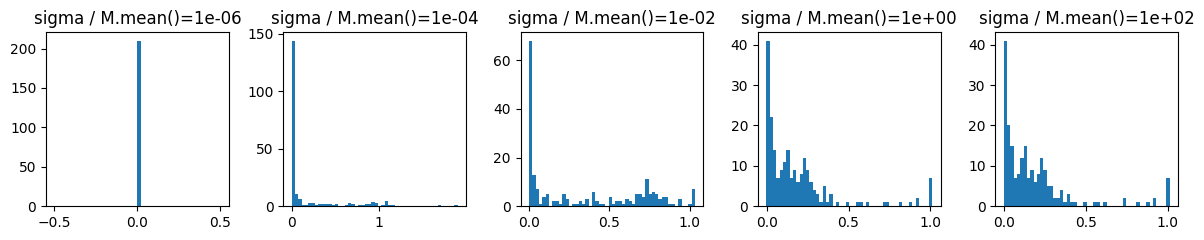

In [5]:
N_NEIGHBORS = 20

mean = dtw_matrix.mean()
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,2.5))
for sigma_rel, ax in zip(
    [1e-6, 1e-4, 1e-2, 1e-0, 1e+2],
    axes.flatten()
):
    weight_matrix = laplacian_score.compute_weight_matrix(
        dataset,
        n_neighbors=N_NEIGHBORS,
        sigma=sigma_rel * mean,
        precomputed_distances=dtw_matrix
    )
    lscores = laplacian_score.laplacian_score(dataset.features, weight_matrix)
    ax.hist(lscores, bins=50)
    ax.set_title(f'sigma / M.mean()={sigma_rel:1.0e}')

plt.tight_layout()
plt.savefig('figures/laplacian_histograms.png')
plt.show()
plt.close()

**Observations:**
- There are two quasi-stationary phases: one when `sigma` is really small, and one when `sigma`is really large. This is not surprising. With the notations of the report: 
    - When `sigma`tends to zero, $S \rightarrow 0$, so $D \rightarrow 0$ and $L \rightarrow 0$. Given that we added a small $\varepsilon$ in the division for the computation of the Laplacian score, it is thus normal that the scores converge to zero. This corresponds to a situation when every point can only ``see" itself due to the Gaussian kernel.
    - When `sigma` is really large, $S \rightarrow G$. This corresponds to a situation where all neighbors have the same importance due to the high radius of the Gaussian kernel. Thus, the Laplacian scores tends to their values with $S$ was perfectly equal to $G$.
- We observe similar behaviors if we change the dataset.

### Impact of `sigma` on the classification accuracy

Now, let's have a closer look of what happen on the performance when `sigma` veries between $10^{-7}$ and $10^3$:

In [6]:
BASE = 10
START = -7
STOP = 3
NB_POINT = 100
N_FEATURES = 50
N_NEIGHBORS = 10
FORCE_RECOMPUTE = False
DATASETS = [
    Dataset(EARTHQUAKES),
    Dataset(WAFER),
    Dataset(WORMS),
]
N_FEATURES = [30, 80, 150]

# Pre-loading from disk
for dataset in DATASETS:
    _ = dataset.ned_distance_matrix
    _ = dataset.dtw_distance_matrix
    _ = dataset.features

# Log space for sigma values
sigma_values = np.logspace(start=START, stop=STOP, num=NB_POINT, base=BASE)
dataset_feat_to_accuracies_list = collections.defaultdict(list)

       17268ms INFO  [datasets.py] Initiating dataset Earthquakes
       17270ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Earthquakes
       17273ms INFO  [datasets.py] Initiating dataset Wafer
       17274ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=Wafer
       17276ms INFO  [datasets.py] Initiating dataset WormsTwoClass
       17277ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
       17430ms INFO  [datasets.py] Extracting the features of 461 time series
       18030ms INFO  [datasets.py] Extracting the features of 2000 time series
       18172ms INFO  [datasets.py] Extracting the features of 258 time series


In [7]:
# Computing the accuracy
CACHE_PATH = Path('saved_results/dataset_feat_to_accuracies_list.pkl')

if not FORCE_RECOMPUTE and CACHE_PATH.exists():
    with open('saved_results/dataset_feat_to_accuracies_list.pkl', 'rb') as f:
        dataset_feat_to_accuracies_list = pickle.load(f)

else:
    for n_features in N_FEATURES:
        for dataset in DATASETS:
            logger.info(f'Computing the accuracy for {len(sigma_values)} values of sigma with dataset={dataset.name}, n_features={n_features}')
            for sigma in sigma_values:
                feature_selector = laplacian_score.LaplacianSelection(
                    dataset,
                    use_dtw=True,
                    sigma=dataset.dtw_distance_matrix.mean() * sigma,
                    n_neighbors=N_NEIGHBORS,
                    n_features=n_features,
                )
                prec, recall = get_svc_accuracy(
                    dataset.features.T,
                    dataset.labels,
                    feature_selector,
                )
                dataset_feat_to_accuracies_list[dataset.name, n_features].append(prec)

    with CACHE_PATH.open('wb') as f:
        pickle.dump(dataset_feat_to_accuracies_list, f)

       18277ms INFO  [1053710238.py] Plotting simulations of the accuracy


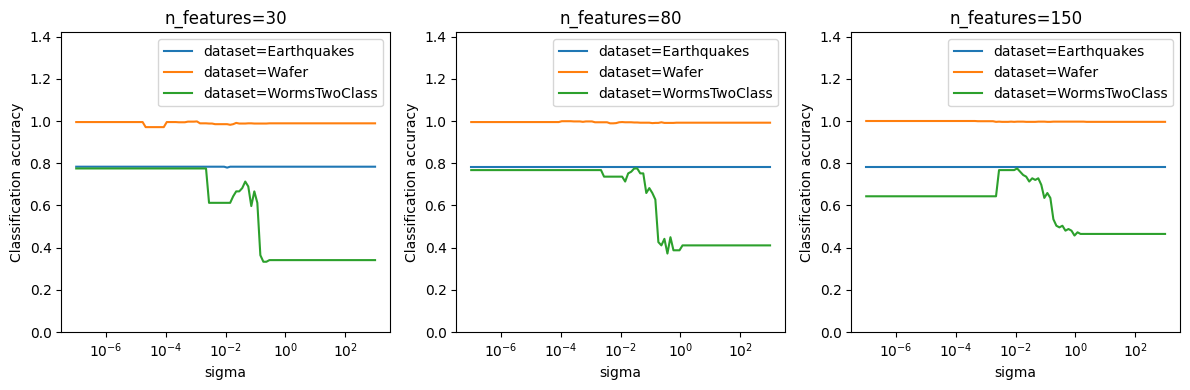

In [8]:
if not FORCE_RECOMPUTE and CACHE_PATH.exists():
    with CACHE_PATH.open('rb') as f:
        dataset_feat_to_accuracies_list = pickle.load(f)

logger.info('Plotting simulations of the accuracy')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for n_features, ax in zip(
    N_FEATURES,
    axes.flatten()
):
    for dataset in DATASETS:
        ax.plot(sigma_values, dataset_feat_to_accuracies_list[dataset.name, n_features], label=f'dataset={dataset.name}')
    ax.set_xscale('log')
    ax.set_ylim(0, 1.42)
    ax.legend()
    ax.set_xlabel('sigma')
    ax.set_ylabel('Classification accuracy')
    ax.set_title(f'n_features={n_features}')

plt.tight_layout() 
plt.savefig('figures/accuracy_vs_sigma.png')
plt.show()
plt.close()

**Observations:**
We observe that:

- For some datasets (namely, Wafer and Earthquakes), the accuracy is quite stable, no matter the value of `sigma` or the number of features selected. This is probably because the classification problem is either too simple or too hard with the features we have. For example with dataset Earthquakes, we observe a performance of $0.8 \simeq 368/461$, which is the proportion of label ``1" in the dataset. No matter the features that are selected, they are not informative enough, and the best that can be done by the SVC is to predict the same label for every sample. 
- In most cases, the best performance comes for low sigma values, around $10^{-4}$. In the case of 150 features selected, the maximum is reached around $10^{-2}$, however this maximum is only equal to the maximum with 30 features. 

Thus, for the stability of the method, it is safe to always take a quite small value for $\sigma/\overline{M}$, yet not too small to to avoid that every Laplace score is equal to $0$.

### Impact of the number of neighbors `k` on the classification accuracy

Now, let's have a look at what happens close to $10^{-1}$, for dataset 'WormsTwoClass'. 

We observe that if we stick to small values of $\sigma / \overline{M}$, the number of neighbors does not really the classification accuracy. To conclude, a good heuristic for the choice of `sigma` and $k$ is to take $\sigma / \overline{M}$ small enough, around $10^{-4}$, and $k$ medium, of the order of ten.

In [9]:
BASE = 10
START = -2
STOP = -0
NB_POINT = 300
N_FEATURES = 80
N_NEIGHBORS = [5, 10, 20, 30]

dataset = Dataset(WORMS)

# Pre-loading from disk
_ = dataset.ned_distance_matrix
_ = dataset.dtw_distance_matrix
_ = dataset.features

# Log space for sigma values
sigma_values = np.logspace(start=START, stop=STOP, num=NB_POINT, base=BASE)
nneighbors_to_accuracies_list = collections.defaultdict(list)

# Computing the accuracy
for n_neighbors in N_NEIGHBORS:
    logger.info(f'Computing the accuracy for {len(sigma_values)} values of sigma with n_neighbors={n_neighbors}')
    for sigma in sigma_values:
        feature_selector = laplacian_score.LaplacianSelection(
            dataset,
            use_dtw=False,
            sigma=dataset.ned_distance_matrix.mean() * sigma,
            n_neighbors=n_neighbors,
            n_features=N_FEATURES,
        )
        prec, recall = get_svc_accuracy(
            dataset.features.T,
            dataset.labels,
            feature_selector,
        )
        nneighbors_to_accuracies_list[n_neighbors].append(prec)

       19483ms INFO  [datasets.py] Initiating dataset WormsTwoClass
       19485ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
       19623ms INFO  [datasets.py] Extracting the features of 258 time series
       19626ms INFO  [377713015.py] Computing the accuracy for 300 values of sigma with n_neighbors=5
       35135ms INFO  [377713015.py] Computing the accuracy for 300 values of sigma with n_neighbors=10
       49960ms INFO  [377713015.py] Computing the accuracy for 300 values of sigma with n_neighbors=20
       64382ms INFO  [377713015.py] Computing the accuracy for 300 values of sigma with n_neighbors=30


       78933ms INFO  [3025642366.py] Plotting simulations of the accuracy


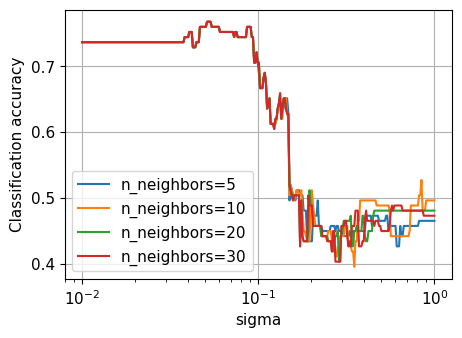

In [10]:
logger.info('Plotting simulations of the accuracy')
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5, 3.5))
for n_neighbors in N_NEIGHBORS:
    plt.plot(sigma_values, nneighbors_to_accuracies_list[n_neighbors], label=f'n_neighbors={n_neighbors}')
plt.xscale('log')
plt.legend()
plt.xlabel('sigma')
plt.ylabel('Classification accuracy')
plt.grid()
# plt.title('Evolution of the classification accuracy aggainst the value of sigma')
plt.savefig('figures/accuracy_vs_sigma_and_nnn.png', bbox_inches='tight')
plt.show()
plt.close()

## Comparison with other methods

Let's compare this method to two others: a variance threshold (unsupervized), and the ANOVA score (supervised).

       79456ms INFO  [datasets.py] Initiating dataset WormsTwoClass
       79459ms INFO  [datasets.py] More info at https://timeseriesclassification.com/description.php?Dataset=WormsTwoClass
       79644ms INFO  [datasets.py] Extracting the features of 258 time series
       79648ms INFO  [1731752185.py] Computing the accuracy over the number of features


100%|██████████| 387/387 [00:45<00:00,  8.47it/s]

      125350ms INFO  [1731752185.py] Plotting simulations of the accuracy


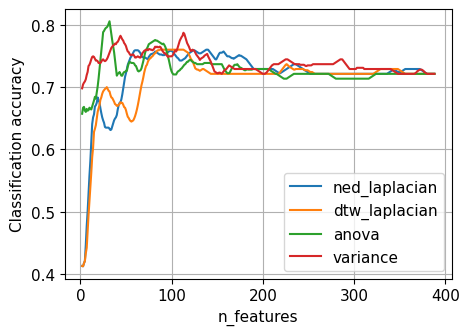

In [11]:
MAX_FEATURES = 500
SIGMA_FACTOR = 5e-2
N_NEIGHBORS = 30
SMOOTHING = 8
SELECTOR_NAME = ['ned_laplacian', 'dtw_laplacian', 'anova', 'variance']

dataset = Dataset(WORMS)
n_features_list = list(range(2, min(dataset.features.shape[0], MAX_FEATURES)))
method_to_acc_list = collections.defaultdict(list)

# Mapping the variance to the number of features

logger.info('Computing the accuracy over the number of features')
for n_features in tqdm(n_features_list):
    
    # Building the feature selectors
    ned_laplacian_selector = laplacian_score.LaplacianSelection(
        dataset,
        use_dtw=False,
        sigma=dataset.ned_distance_matrix.mean() * SIGMA_FACTOR,
        n_neighbors=N_NEIGHBORS,
        n_features=n_features,
    )
    dtw_laplacian_selector = laplacian_score.LaplacianSelection(
        dataset,
        use_dtw=True,
        sigma=dataset.dtw_distance_matrix.mean() * SIGMA_FACTOR,
        n_neighbors=N_NEIGHBORS,
        n_features=n_features,
    )
    anova_selector = SelectKBest(f_classif, k=n_features)
    variance_selector = VarianceSelection(dataset, n_features)

    # Computing accuracy
    for selector, name in zip(
        [ned_laplacian_selector, dtw_laplacian_selector, anova_selector, variance_selector],
        SELECTOR_NAME,
    ):
        method_to_acc_list[name].append(
            get_svc_accuracy(
                dataset.features.T,
                dataset.labels,
                selector,
            )[0]
        )

if SMOOTHING:
    for name in method_to_acc_list:
        method_to_acc_list[name] = (
            np.convolve(method_to_acc_list[name],np.ones(SMOOTHING),'same',)
            / np.convolve(np.ones_like(method_to_acc_list[name]),np.ones(SMOOTHING),'same',)
        )


logger.info('Plotting simulations of the accuracy')
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5, 3.5))
for name in SELECTOR_NAME:
    plt.plot(n_features_list, method_to_acc_list[name], label=f'{name}')
plt.legend()
plt.xlabel('n_features')
plt.ylabel('Classification accuracy')
plt.grid()
# plt.title('Evolution of the classification accuracy aggainst the number of features')
plt.savefig('figures/accuracy_vs_n_features.png', bbox_inches='tight')
plt.show()
plt.close()


We observe that the method based on the Laplace score has similar performances to these two techniques, and is even better on certain ranges of values. However, for a limited number of features, the performance gap remains important, and constitutes a major disadvantage of the method. Finally, we observe that contrary to what we could have intuitively imagined, the performances are not improved, on the contrary, by using the DTW, and this even if DTW is generally considered more relevant for time series. 

## Conclusion

Our experiments identified heuristics for choosing sigma and the number of neighbors in the absence of additional knowledge about the data. Moreover, our experiments have shown that this method leads to relatively good performances compared to other widely used methods such as the ANOVA score, although they remain slightly inferior.